In [1]:
import os
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import sigmaclip

import GCRCatalogs
from lsst.daf.persistence import Butler
import lsst.geom as geom

import data_process_utils as dpu

In [2]:
!pwd

/global/cfs/cdirs/desc-sn/dia/data/shl159/projects/dia_improvement/scripts


In [3]:
import imp
imp.reload(dpu) 

<module 'data_process_utils' from '/global/cfs/cdirs/desc-sn/dia/data/shl159/projects/dia_improvement/scripts/data_process_utils.py'>

In [4]:
def get_sky_boundary(bbox, wcs):
    # get the bouding radec of the exposure
    begin_x, begin_y = bbox.beginX, bbox.beginY
    end_x, end_y = bbox.endX, bbox.endY
    print('begin x: ', begin_x, 'begin y: ', begin_y, 'end x: ', end_x, 'end y: ', end_y)
    sky_00 = geom.SpherePoint(wcs.pixelToSky(begin_x, begin_y))
    sky_01 = geom.SpherePoint(wcs.pixelToSky(begin_x, end_y))
    sky_10 = geom.SpherePoint(wcs.pixelToSky(end_x, begin_y))
    sky_11 = geom.SpherePoint(wcs.pixelToSky(end_x, end_y))
    ras = np.array([sky_00.getRa().asDegrees(), sky_01.getRa().asDegrees(),
                   sky_10.getRa().asDegrees(), sky_11.getRa().asDegrees()])
    ras.sort()
    decs = np.array([sky_00.getDec().asDegrees(), sky_01.getDec().asDegrees(),
                   sky_10.getDec().asDegrees(), sky_11.getDec().asDegrees()])
    decs.sort()
    radec_dict = {
        'begin_ra': ras[1], 'end_ra': ras[2],
        'begin_dec': decs[1], 'end_dec': decs[2]
    }
    return radec_dict

def measure_local_phot(exp, sky, ra, dec, photocalib, cutout_size):
    # measure local photometry of host galaxy, ra and dec are in degrees.
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    # radec = geom.SpherePoint(exp.getWcs().pixelToSky(x, y))
    radec = geom.SpherePoint(ra * geom.degrees, dec * geom.degrees)
    cutout_exp = exp.getCutout(radec, cutout_extent)
    
    img = cutout_exp.getImage().array
    var = cutout_exp.getVariance().array
    nan_id = np.isnan(img)
    img = img[~nan_id]
    var = var[~nan_id]
    
    
    signal = np.sum(img - sky)
    noise = np.sqrt(np.sum(var))
    
    mag_measurement = photocalib.instFluxToMagnitude(signal, noise)
    
    return signal, noise, mag_measurement.value, mag_measurement.error

def get_host(coadd, gal_df, min_mag, max_mag, gal_size=20, sep_dist=100):
    # select gal_size number of galaxies with mag between min_mag and max_mag
    gal_cut = gal_df[np.logical_and(gal_df.mag > min_mag, gal_df.mag <= max_mag)].reset_index(drop=True)
    coadd_wcs = coadd.getWcs()
    bbox = coadd.getBBox()
    begin_x = bbox.beginX
    begin_y = bbox.beginY

    coord_list = []
    for index, row in gal_cut.iterrows():
        ra, dec = row['ra'], row['dec']
        x, y = dpu.radec2xy(ra, dec, coadd_wcs)
        x = x - begin_x
        y = y - begin_y
        coord_list.append([x, y])

    coord_xy = np.array(coord_list)
    gal_cut['coadd_pixel_x'] = coord_xy[:,0]
    gal_cut['coadd_pixel_y'] = coord_xy[:,1]
        
    dist = dpu.cal_xy_dist(coord_xy, coord_xy)
    keep_list = dpu.sep_coord(dist, sep_dist)
    gal_cut = gal_cut.iloc[keep_list].reset_index(drop=True)
    if len(gal_cut) < gal_size:
        return gal_cut
    gal_cut = gal_cut.iloc[0: gal_size].reset_index()
    return gal_cut

def query_data(conn, tract, patch, filt):
    # select visits which overlap the patch
    query = (f"select distinct(visit), filter, detector, tract, patch from overlaps where tract={tract} " 
         f"and patch='{patch}' and filter='{filt}' order by visit")
    calexp_info = pd.read_sql_query(query, conn)
    return calexp_info

In [5]:
# get coadd repo
coadd_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
coadd_butler = Butler(coadd_repo)

print('loading coadds')
# get coadd images
coadd_dict = {}
for i in range(7):
    coadd = coadd_butler.get('deepCoadd',  {'tract': 4639, 'patch': f'{i},{i}', 'filter': 'i'})
    coadd_dict[f'{i}{i}'] = coadd
    wcs = coadd.getWcs()
    pixel_scale = wcs.getPixelScale
    print(f'patch {i}{i}: ', pixel_scale, '\n')

print('measuring coadd boundaries')
# get boundaries of coadds
boundary_dict = {}
for i in range(7):
    coadd = coadd_dict[f'{i}{i}']
    boundary = get_sky_boundary(coadd.getBBox(), coadd.getWcs())
    boundary_dict[f'{i}{i}'] = boundary
    
print('getting photoCalib')
# get photoCalib
coadd_calib_dict = {}
for i in range(7):
    coadd_id = {'tract': 4639, 'patch': f'{i},{i}', 'filter': 'i'}
    coadd_photocalib = coadd_butler.get('deepCoadd_photoCalib', coadd_id)
    coadd_calib_dict[f'{i}{i}'] = coadd_photocalib
print('done')

loading coadds
patch 00:  <bound method PyCapsule.getPixelScale of FITS standard SkyWcs:
Sky Origin: (56.303318, -30.495868)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel> 

patch 11:  <bound method PyCapsule.getPixelScale of FITS standard SkyWcs:
Sky Origin: (56.303318, -30.495868)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel> 

patch 22:  <bound method PyCapsule.getPixelScale of FITS standard SkyWcs:
Sky Origin: (56.303318, -30.495868)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel> 

patch 33:  <bound method PyCapsule.getPixelScale of FITS standard SkyWcs:
Sky Origin: (56.303318, -30.495868)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel> 

patch 44:  <bound method PyCapsule.getPixelScale of FITS standard SkyWcs:
Sky Origin: (56.303318, -30.495868)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel> 

patch 55:  <bound method PyCapsule.getPixelScale of FITS standard SkyWcs:
Sky Origin: (56.303318, -30.495868)
Pixel Origin: (

In [6]:
0.2 * 3900 * 0.2 * 3900 / 3600

169.0

In [7]:
"""
print('getting galaxy information from GCR catalog')

# read gcr catalog
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
os.makedirs('../data/table/gal_4639/', exist_ok=True)

# define magnitude range, tract, and band
min_mag = 10
max_mag = 30
tract = 4639
filt = 'i'

# get galaxy information from the gcr catalog
gal_df = pd.DataFrame()
for i in range(7):
    boundary = boundary_dict[f'{i}{i}']
    begin_ra = boundary['begin_ra']
    end_ra = boundary['end_ra']
    begin_dec = boundary['begin_dec']
    end_dec = boundary['end_dec']
    galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_i', 'halo_id'],
                                filters=[f'mag_i > {min_mag}', f'mag_i < {max_mag}',
                                         f'ra > {begin_ra}', f'ra < {end_ra}',
                                        f'dec > {begin_dec}', f'dec < {end_dec}'])
    gal_radec = pd.DataFrame(galaxy_data)
    gal_radec['tract'] = np.repeat(tract, len(gal_radec))
    gal_radec['patch_1'] = np.repeat(i, len(gal_radec))
    gal_radec['patch_2'] = np.repeat(i, len(gal_radec))
    gal_radec['filter'] = np.repeat(f'{filt}', len(gal_radec))
    gal_df = gal_df.append(gal_radec)
gal_df = gal_df.reset_index(drop=True)

# remove galalies near the edge
print('# of pixels ignored', (200 * 4100 * 4 - 200 * 200 * 4) / 4100 / 4100 ) # 0.18560380725758477

edge_size = 200

x_list = []
y_list = []
for idx, row in gal_df.iterrows():
    patch1 = row['patch_1']
    patch2 = row['patch_2']
    coadd = coadd_dict[f'{patch1}{patch2}']
    wcs = coadd.getWcs()
    bbox = coadd.getBBox()
    begin_x = bbox.beginX
    end_x = bbox.endX
    x_len = end_x - begin_x
    begin_y = bbox.beginY
    end_y = bbox.endY
    y_len = end_y - begin_y
    
    ra, dec = row['ra'], row['dec']
    x, y = dpu.radec2xy(ra, dec, wcs)
    x = x - begin_x
    y = y - begin_y
    x_list.append(x)
    y_list.append(y)
    
x_arr = np.array(x_list)
y_arr = np.array(y_list)
    
remove_edge = (x_arr < edge_size) \
    + (x_len - x_arr < edge_size) \
    + (y_arr < edge_size) \
    + (y_len - y_arr < edge_size) 
gal_cut = gal_df[~remove_edge].reset_index(drop=True)


dbpath = '../data/table/gal_4639/gal_info.sqlite'
dbconn = sqlite3.connect(dbpath, timeout=60)
gal_cut.to_sql('gal_info', dbconn, if_exists='replace')

print(f'galaxy information has been saved in {dbpath}')
"""
print()

## measure local s/n

reading galaxy information
index        int64
halo_id      int64
mag_i      float64
dec        float64
ra         float64
tract        int64
patch_1      int64
patch_2      int64
filter      object
dtype: object
measuring sky background
The distribution is quite sharp, coadd is almost noiseless.
measuring local magnitude
pixel scale is 0.2 arcsec/pixel for all patches
we choose 5 * 5 pixel aperture, which corresponds to 1. arcsec^2 aperture (DES use 1.3 arcsec^2)
Index(['index', 'halo_id', 'mag_i', 'dec', 'ra', 'tract', 'patch_1', 'patch_2',
       'filter', 'signal', 'error', 'mag', 'mag_err'],
      dtype='object')
Index(['index', 'halo_id', 'mag_i', 'dec', 'ra', 'tract', 'patch_1', 'patch_2',
       'filter', 'signal', 'error', 'mag', 'mag_err', 's2n'],
      dtype='object')
local s2n information of hosts has been saved in ../data/table/gal_4639/gal_s2n.sqlite


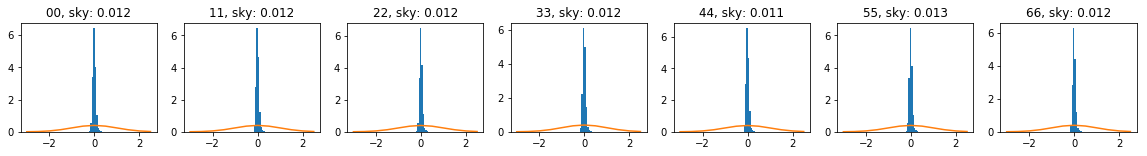

In [8]:
"""
print('reading galaxy information')
dbpath = '../data/table/gal_4639/gal_info.sqlite'
dbconn = sqlite3.connect(dbpath, timeout=60)
query = (f'SELECT * FROM gal_info')
gal_cut = pd.read_sql_query(query, dbconn)
print(gal_cut.dtypes)

print('measuring sky background')
sky_dict = {}
fig, ax = plt.subplots(1,7, figsize=(20, 2))
rv = norm(loc=0, scale=1)
for i in range(7):
    coadd_id = {'tract': 4639, 'patch': f'{i},{i}', 'filter': 'i'}
    coadd = coadd_dict[f'{i}{i}']
    image = coadd.getImage().array
    nan_mask = np.isnan(image)
    image = image[~nan_mask]
    clipped, _, _ = sigmaclip(image, low=5, high=5)
    sky = np.mean(clipped)
    sky_dict[f'{i}{i}'] = sky
    ax[i].hist(clipped - sky, density=True)
    x = np.arange(-3, 3, 0.5)
    ax[i].plot(x, rv.pdf(x))
    ax[i].set_title(f'{i}{i}, sky: {sky:.3f}')

print('The distribution is quite sharp, coadd is almost noiseless.')
# measure local magnitude      
print('measuring local magnitude')
print('pixel scale is 0.2 arcsec/pixel for all patches')
print('we choose 5 * 5 pixel aperture, which corresponds to 1. arcsec^2 aperture (DES use 1.3 arcsec^2)')

psf_shape = 5 # psf size

signal_list = []
error_list = []
mag_list = []
mag_err_list = []

for idx, row in gal_cut.iterrows():

    patch_1 = row['patch_1']
    patch_2 = row['patch_2']

    coadd = coadd_dict[f'{patch_1}{patch_2}']
    sky = sky_dict[f'{patch_1}{patch_2}']
    coadd_photocalib = coadd_calib_dict[f'{patch_1}{patch_2}']
    
    ra = row['ra']
    dec = row['dec']
    
    signal, error, mag, mag_err = measure_local_phot(coadd, sky, ra, dec, coadd_photocalib, cutout_size=psf_shape)
    signal_list.append(signal)
    error_list.append(error)
    mag_list.append(mag)
    mag_err_list.append(mag_err)
gal_cut['signal']  = signal_list
gal_cut['error'] = error_list
gal_cut['mag'] = mag_list
gal_cut['mag_err'] = mag_err_list

gal_s2n = gal_cut.copy()
print(gal_s2n.columns)
gal_s2n['s2n'] = gal_s2n.signal / gal_s2n.error
print(gal_s2n.columns)
dbpath = '../data/table/gal_4639/gal_s2n.sqlite'
dbconn = sqlite3.connect(dbpath, timeout=60)
gal_s2n.to_sql('gal_s2n', dbconn, if_exists='replace')
print(f'local s2n information of hosts has been saved in {dbpath}')
"""
print()

## sort by s2n

In [7]:
dbpath = '../data/table/gal_4639/gal_s2n.sqlite'
dbconn = sqlite3.connect(dbpath, timeout=60)
query = (f'SELECT * FROM gal_s2n')
gal_s2n = pd.read_sql_query(query, dbconn)
print(gal_s2n.columns)
print('compare index and level_0: ', np.sum(gal_s2n.index - gal_s2n.level_0))
# drop level_0
gal_s2n = gal_s2n.drop(columns='level_0')

Index(['level_0', 'index', 'halo_id', 'mag_i', 'dec', 'ra', 'tract', 'patch_1',
       'patch_2', 'filter', 'signal', 'error', 'mag', 'mag_err', 's2n'],
      dtype='object')
compare index and level_0:  0


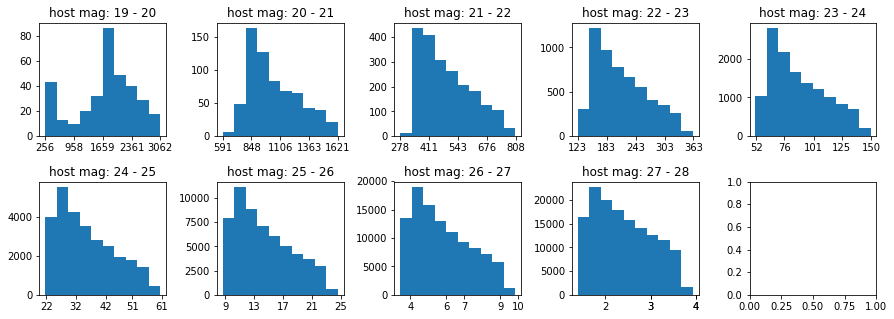

In [8]:
host_mag_range_list = [(19, 20), (20, 21), (21, 22), (22,23),
                       (23, 24), (24, 25), (25, 26), (26, 27), (27, 28)]
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axf = ax.flat

for i, host_mag_range in enumerate(host_mag_range_list):
    min_mag, max_mag = host_mag_range[0], host_mag_range[1]
    gal_s2n_slice = gal_s2n[np.logical_and(gal_s2n.mag>min_mag, gal_s2n.mag<max_mag)].copy()
    s2n = gal_s2n_slice.s2n
    min_x = np.min(s2n)
    max_x = np.max(s2n)
    ticks = np.ceil(np.linspace(min_x, max_x, 5)).astype(int)
    axf[i].set_xticks(ticks)
    axf[i].set_xticklabels(ticks)
    axf[i].set_title(f'host mag: {min_mag} - {max_mag}')
    # axf[i].set_ylim(0, 25000)
    axf[i].hist(s2n)

In [9]:
host_mag_list = ['19_20', '20_21', '21_22', '22_23',
                 '23_24', '24_25', '25_26', '26_27', '27_28']
host_mag_range_list = [(19, 20), (20, 21), (21, 22), (22,23),
                       (23, 24), (24, 25), (25, 26), (26, 27), (27, 28)]
s2n_range_list = [(1500, 3000), (800, 1500), (350, 800), (150, 350),
                  (50, 150), (25, 50), (10, 25), (5, 10), (0, 5)]

In [10]:
mag_dict = dict(zip(host_mag_list, host_mag_range_list))
mag2s2n_dict = dict(zip(host_mag_list, s2n_range_list))

In [11]:
gal_mag2s2n = pd.DataFrame()
for i, host_mag in enumerate(host_mag_list):
    host_mag_range = mag_dict[host_mag]
    s2n_range = mag2s2n_dict[host_mag]
    min_mag, max_mag = host_mag_range[0], host_mag_range[1]
    min_s2n, max_s2n = s2n_range[0], s2n_range[1]
    slice_index = np.logical_and.reduce([
        gal_s2n.mag>min_mag, gal_s2n.mag<max_mag,
        gal_s2n.s2n>min_s2n, gal_s2n.s2n<max_s2n
    ])
    gal_df_tmpt = gal_s2n.loc[slice_index].copy().reset_index(drop=True)
    gal_mag2s2n = gal_mag2s2n.append(gal_df_tmpt)
gal_mag2s2n = gal_mag2s2n.reset_index(drop=True)

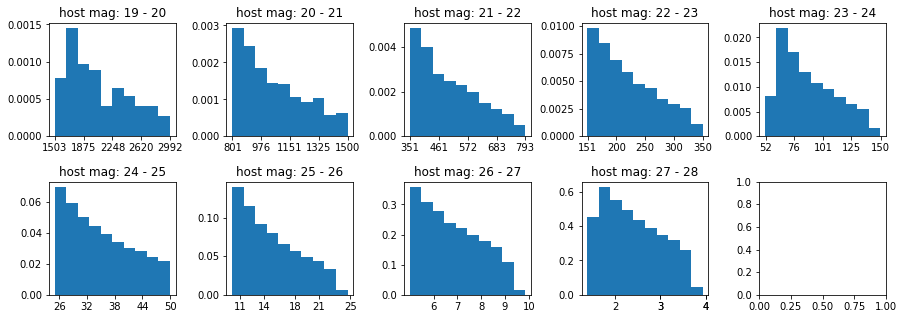

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axf = ax.flat

for i, host_mag_range in enumerate(host_mag_range_list):
    min_mag, max_mag = host_mag_range[0], host_mag_range[1]
    gal_s2n_slice = gal_mag2s2n[np.logical_and(gal_mag2s2n.mag>min_mag, gal_mag2s2n.mag<max_mag)].copy()
    s2n = gal_s2n_slice.s2n
    min_x = np.min(s2n)
    max_x = np.max(s2n)
    ticks = np.ceil(np.linspace(min_x, max_x, 5)).astype(int)
    axf[i].set_xticks(ticks)
    axf[i].set_xticklabels(ticks)
    axf[i].set_title(f'host mag: {min_mag} - {max_mag}')
    axf[i].hist(s2n, density=True)

In [13]:
# select 20 galaxies at each magnitude level

print('selecting 20 galaxies at each magnitude level')

host_mag_list = ['19_20', '20_21', '21_22', '22_23',
                 '23_24', '24_25', '25_26', '26_27', '27_28']
host_mag_range_list = [(19, 20), (20, 21), (21, 22), (22,23),
                       (23, 24), (24, 25), (25, 26), (26, 27), (27, 28)]
s2n_range_list = [(1500, 3000), (800, 1500), (350, 800), (150, 350),
                  (50, 150), (25, 50), (10, 25), (5, 10), (0, 5)]
mag_dict = dict(zip(host_mag_list, host_mag_range_list))
mag2s2n_dict = dict(zip(host_mag_list, s2n_range_list))

gal_size = 20 # select 20 galaxies
sep_dist = 100 # each galaxy is at least 100 pixels away from another

gal_s2n_cut20 = pd.DataFrame()
for i in range(7):
    print(f'patch {i}{i}')
    gal_patch = gal_mag2s2n.loc[np.logical_and(gal_mag2s2n.patch_1==i, gal_mag2s2n.patch_2==i)].copy(deep=True).reset_index(drop=True)
    coadd = coadd_dict[f'{i}{i}']
    
    for host_mag in host_mag_list:
        print(host_mag)
        host_mag_range = mag_dict[host_mag]
        s2n_range = mag2s2n_dict[host_mag]
        
        min_mag = host_mag_range[0]
        max_mag = host_mag_range[1]
        min_s2n = s2n_range[0]
        max_s2n = s2n_range[1]
        
        gal_sep = get_host(coadd, gal_patch.copy(), min_mag, max_mag, gal_size=gal_size, sep_dist=sep_dist)

        gal_sep['min_host_mag'] = np.repeat(min_mag, len(gal_sep))
        gal_sep['max_host_mag'] = np.repeat(max_mag, len(gal_sep))
        
        gal_sep['min_host_s2n'] = np.repeat(min_s2n, len(gal_sep))
        gal_sep['max_host_s2n'] = np.repeat(max_s2n, len(gal_sep))
        
        gal_s2n_cut20 = gal_s2n_cut20.append(gal_sep)
    print('\n')
gal_s2n_cut20 = gal_s2n_cut20.reset_index(drop=True)
print('monitoring dtypes')
print(gal_s2n_cut20.dtypes)
print('\n')

selecting 20 galaxies at each magnitude level
patch 00
19_20
20_21
21_22
22_23


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


23_24
24_25
25_26
26_27
27_28


patch 11
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28


patch 22
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28


patch 33
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28


patch 44
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28


patch 55
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28


patch 66
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28


monitoring dtypes
coadd_pixel_x      int64
coadd_pixel_y      int64
dec              float64
error            float64
filter            object
halo_id            int64
index              int64
level_0          float64
mag              float64
mag_err          float64
mag_i            float64
max_host_mag       int64
max_host_s2n       int64
min_host_mag       int64
min_host_s2n       int64
patch_1            int64
patch_2            int64
ra               float64
s2n              float64
signal           float64
tract              int64
dtype: object




In [14]:
for i in range(7):
    print(f'patch {i}')
    for host_mag_range in host_mag_range_list:
        min_mag, max_mag = host_mag_range[0], host_mag_range[1]

        tmpt_df = gal_s2n_cut20[np.logical_and.reduce(
            [gal_s2n_cut20.mag>min_mag, gal_s2n_cut20.mag<max_mag, gal_s2n_cut20.patch_1==i]
        )]
        print(f'{min_mag}{max_mag}: {len(tmpt_df)}')
    print('\n')


patch 0
1920: 19
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20


patch 1
1920: 20
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20


patch 2
1920: 20
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20


patch 3
1920: 20
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20


patch 4
1920: 20
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20


patch 5
1920: 20
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20


patch 6
1920: 20
2021: 20
2122: 20
2223: 20
2324: 20
2425: 20
2526: 20
2627: 20
2728: 20




In [15]:


# select visits
print('selecting visits which overlap patches')

conn = sqlite3.connect('/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1/tracts_mapping.sqlite3')
calexp_info_dict = {}
for i in range(7):
    calexp_info = query_data(conn, tract=4639, patch=(i, i), filt='i')
    calexp_info_dict[f'{i}{i}'] = calexp_info

# select 10 visits per patch

print('select 10 visits for each patch')

calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)

tract = 4639
filt = 'i'

edge_size = 200
calexp_per_coadd = 10

coadd_calexp_df = pd.DataFrame()

for i in range(7):
    print('patch: ', i)
    calexp_info = calexp_info_dict[f'{i}{i}']
    gal_s2n_patch = gal_s2n_cut20.loc[
        np.logical_and(gal_s2n_cut20.patch_1==i, gal_s2n_cut20.patch_2==i)
    ]
    
    
    for host_mag in host_mag_list:
        host_mag_range = mag_dict[host_mag]
        s2n_range = mag2s2n_dict[host_mag]
        
        min_mag = host_mag_range[0]
        max_mag = host_mag_range[1]
        min_s2n = s2n_range[0]
        max_s2n = s2n_range[1]
        
        print('mag', min_mag, max_mag)
        gal_mag = gal_s2n_patch.loc[
            np.logical_and(gal_s2n_patch.min_host_mag==min_mag, gal_s2n_patch.max_host_mag==max_mag)
        ].copy().reset_index(drop=True)
        coord_array = gal_mag[['ra', 'dec']].to_numpy()
        visit_list = []
        overlap_count = []
        for index, row in calexp_info.iterrows():
            visit, detector = row['visit'], row['detector']
            calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
            calexp_wcs = calexp_butler.get('calexp_wcs', dataId=calexp_id)
            calexp_bbox = calexp_butler.get('calexp_bbox', dataId=calexp_id)
            tof_results = dpu.coord_in_image(coord_array, calexp_wcs, calexp_bbox, offset=edge_size)
            tof_sum = np.sum(tof_results)
            overlap_count.append(tof_sum)
            if tof_sum > 20:
                print(tof_sum, visit, detector)
            if tof_sum >=5:
                visit_list.append(index) 

        calexp_info_copy = calexp_info.copy()
        calexp_info_copy['overlap_count'] = overlap_count
        calexp_info_copy = calexp_info_copy.iloc[visit_list].reset_index(drop=True)
        calexp_info_copy = calexp_info_copy.sort_values(by=['overlap_count'],
                                                        ascending=False).reset_index(drop=True)
        calexp_info_copy = calexp_info_copy.iloc[0: calexp_per_coadd].reset_index(drop=True)
        calexp_info_copy['patch_1'] = np.repeat(i, calexp_per_coadd)
        calexp_info_copy['patch_2'] = np.repeat(i, calexp_per_coadd)
        calexp_info_copy['min_host_mag'] = np.repeat(min_mag, calexp_per_coadd)
        calexp_info_copy['max_host_mag'] = np.repeat(max_mag, calexp_per_coadd)
        calexp_info_copy['min_host_s2n'] = np.repeat(min_s2n, calexp_per_coadd)
        calexp_info_copy['max_host_s2n'] = np.repeat(max_s2n, calexp_per_coadd)

        coadd_calexp_df = coadd_calexp_df.append(calexp_info_copy)
    print('\n')
print('monitoring dtypes')
print(coadd_calexp_df.dtypes)
print('\n')

selecting visits which overlap patches
select 10 visits for each patch
patch:  0
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


patch:  1
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


patch:  2
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


patch:  3
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


patch:  4
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


patch:  5
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


patch:  6
mag 19 20
mag 20 21
mag 21 22
mag 22 23
mag 23 24
mag 24 25
mag 25 26
mag 26 27
mag 27 28


monitoring dtypes
visit              int64
filter            object
detector           int64
tract              int64
patch             object
overlap_count    float64
patch_1            int64
patch_2            int

In [16]:
# injection_list
print('getting injection coordinates')
edge_size = 200
injection_coord_df = pd.DataFrame()

for i in range(7):
    print(f'patch {i}{i}')
    
    for host_mag in host_mag_list:
        print(host_mag)
        host_mag_range = mag_dict[host_mag]
        s2n_range = mag2s2n_dict[host_mag]
        
        min_mag = host_mag_range[0]
        max_mag = host_mag_range[1]
        min_s2n = s2n_range[0]
        max_s2n = s2n_range[1]
        
        coadd_calexp_patch = coadd_calexp_df.loc[coadd_calexp_df.patch_1==i]
        gal_s2n_patch = gal_s2n_cut20.loc[gal_s2n_cut20.patch_1==i]
        
        visit_info = coadd_calexp_patch.loc[np.logical_and(
            coadd_calexp_patch.min_host_mag==min_mag, coadd_calexp_patch.max_host_mag==max_mag).copy(deep=True)
                                           ]
        host_info = gal_s2n_patch.loc[np.logical_and(
            gal_s2n_patch.min_host_mag==min_mag, gal_s2n_patch.max_host_mag==max_mag).copy(deep=True)
                                     ]
        for index, row in visit_info.iterrows():
            visit = row['visit']
            filt = row['filter']
            detector = row['detector']
            calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
            calexp_wcs = calexp_butler.get('calexp_wcs', dataId=calexp_id)
            calexp_bbox = calexp_butler.get('calexp_bbox', dataId=calexp_id)
            
            ra_list = []
            dec_list = []
            x_list = []
            y_list = []
            
            host_signal_list = []
            host_signal_err_list = []
            host_s2n_list = []
            host_magnitude_list = []
            host_mag_err_list = []
            for gal_idx, gal_row in host_info.iterrows():
                ra, dec = gal_row['ra'], gal_row['dec']
                

                
                if dpu.in_image(ra, dec, calexp_wcs, calexp_bbox, offset=edge_size):
                    x, y = dpu.radec2xy(ra, dec, calexp_wcs)
                    x_list.append(x)
                    y_list.append(y)
                    ra_list.append(ra)
                    dec_list.append(dec)
                    host_signal_list.append(gal_row['signal'])
                    host_signal_err_list.append(gal_row['error'])
                    host_s2n_list.append(gal_row['s2n'])
                    host_magnitude_list.append(gal_row['mag'])
                    host_mag_err_list.append(gal_row['mag_err'])
            
            injection_dict = {}
            
            injection_dict['host_image_sum'] = host_signal_list
            injection_dict['host_image_sum_err'] = host_signal_err_list
            injection_dict['host_s2n'] = host_s2n_list
            injection_dict['host_mag'] = host_magnitude_list
            injection_dict['host_mag_err'] = host_mag_err_list

            injection_dict['calexp_coord_x'] = x_list
            injection_dict['calexp_coord_y'] = y_list
            injection_dict['ra'] = ra_list
            injection_dict['dec'] = dec_list
            injection_dict['visit'] = [visit for j in range(len(x_list))]
            injection_dict['detector'] = [detector for j in range(len(x_list))]
            injection_dict['filter'] = [filt for j in range(len(x_list))]
            injection_dict['tract'] = [tract for j in range(len(x_list))]
            injection_dict['patch_1'] = [i for j in range(len(x_list))]
            injection_dict['patch_2'] = [i for j in range(len(x_list))]
            injection_dict['min_host_mag'] = [min_mag for j in range(len(x_list))]
            injection_dict['max_host_mag'] = [max_mag for j in range(len(x_list))]
            injection_dict['min_host_s2n'] = [min_s2n for j in range(len(x_list))]
            injection_dict['max_host_s2n'] = [max_s2n for j in range(len(x_list))]
            injection_df = pd.DataFrame.from_dict(injection_dict, orient='columns')
            injection_coord_df = injection_coord_df.append(injection_df)
            
injection_coord_df = injection_coord_df.reset_index(drop=True)

print('monitoring dtypes')
print(injection_coord_df.dtypes)
print('\n')

dbpath = '../data/table/gal_4639/injection_coord.sqlite'
dbconn = sqlite3.connect(dbpath, timeout=60)
injection_coord_df.to_sql('injection_coord', dbconn, if_exists='replace')

print('done')

getting injection coordinates
patch 00
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
patch 11
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
patch 22
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
patch 33
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
patch 44
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
patch 55
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
patch 66
19_20
20_21
21_22
22_23
23_24
24_25
25_26
26_27
27_28
monitoring dtypes
host_image_sum        float64
host_image_sum_err    float64
host_s2n              float64
host_mag              float64
host_mag_err          float64
calexp_coord_x          int64
calexp_coord_y          int64
ra                    float64
dec                   float64
visit                   int64
detector                int64
filter                 object
tract                   int64
patch_1                 int64
patch_2                 int64
min_host_mag            int64
max_host_mag            int64
m

# host count test

In [11]:
"""
for i in range(7):
    print('patch: ', i)
    for host_mag in host_mag_range_list:
        min_mag, max_mag = host_mag[0], host_mag[1]
        ccyy = injection_coord_df.loc[np.logical_and(
            injection_coord_df.min_host_mag==min_mag,
            injection_coord_df.patch_1==i)]
        
        print(host_mag, ':', len(ccyy))
    print('\n')
"""
print()

In [12]:
"""
for i in range(7):
    ycy = coadd_calexp_df[coadd_calexp_df.patch_1==i]
    ccyy = ycy.groupby(by=['min_host_mag', 'overlap_count']).count()
    print(ccyy)
"""
print()

In [13]:
"""
for i in range(7):
    print('patch: ', i)
    for host_mag in host_mag_range_list:
        min_mag, max_mag = host_mag[0], host_mag[1]
        ccyy = coadd_calexp_df.loc[np.logical_and(
            coadd_calexp_df.min_host_mag==min_mag,
            coadd_calexp_df.patch_1==i)]
        
        print(host_mag, ':', len(ccyy))
    print('\n')
"""
print()

# local photometry test

In [17]:
conn = sqlite3.connect('../data/table/gal_4639/injection_coord.sqlite')
query = (f'SELECT * FROM injection_coord')
gal_info_df = pd.read_sql_query(query, conn)

In [19]:
# get coadd repo
coadd_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
coadd_butler = Butler(coadd_repo)

# get coadd images
coadd_dict = {}
for i in range(7):
    coadd_dict[f'{i}{i}'] = coadd_butler.get('deepCoadd',  {'tract': 4639, 'patch': f'{i},{i}', 'filter': 'i'})

In [20]:
host_mag_range_list = [(19, 20), (20, 21), (21, 22), (22,23),
                       (23, 24), (24, 25), (25, 26), (26, 27), (27, 28)]

In [21]:
sky_dict = {}
for i in range(7):
    coadd_id = {'tract': 4639, 'patch': f'{i},{i}', 'filter': 'i'}
    coadd = coadd_dict[f'{i}{i}']
    image = coadd.getImage().array
    nan_mask = np.isnan(image)
    image = image[~nan_mask]
    clipped, _, _ = sigmaclip(image, low=5, high=5)
    sky = np.mean(clipped)
    sky_dict[f'{i}{i}'] = sky
    
coadd_calib_dict = {}
for i in range(7):
    coadd_id = {'tract': 4639, 'patch': f'{i},{i}', 'filter': 'i'}
    coadd_photocalib = coadd_butler.get('deepCoadd_photoCalib', coadd_id)
    coadd_calib_dict[f'{i}{i}'] = coadd_photocalib

In [25]:
comparison_result = []
compare_s2n = []
min_mag_list = []
max_mag_list = []
mag_list = []
res_list = []

for host_mag in host_mag_range_list:
    min_mag, max_mag = host_mag[0], host_mag[1]
    gal_mag_df = gal_info_df.loc[np.logical_and(
        gal_info_df.min_host_mag==min_mag, gal_info_df.max_host_mag==max_mag
    )]
    for idx, row in gal_mag_df.iterrows():
        patch_1, patch_2 = row['patch_1'], row['patch_2']
        ra, dec = row['ra'], row['dec']
        coadd = coadd_dict[f'{patch_1}{patch_2}']
        sky = sky_dict[f'{patch_1}{patch_2}']
        photocalib = coadd_calib_dict[f'{patch_1}{patch_2}']
        flux, _, mag, _ = measure_local_phot(coadd, sky, ra, dec, photocalib, 5)
        tof = ( (min_mag < mag) and (mag < max_mag) )
        comparison_result.append(tof==False)
        compare_s2n.append(
            ( (row['min_host_s2n'] < row['host_s2n']) and (row['host_s2n'] < row['max_host_s2n']) ) == False
        )
        min_mag_list.append(min_mag)
        max_mag_list.append(max_mag)
        mag_list.append(mag)
        res_list.append((flux - row['host_image_sum']) / row['host_image_sum'])
result_arr = np.array(comparison_result)
mag_arr = np.array(mag_list)
min_mag_arr = np.array(min_mag_list)
max_mag_arr = np.array(max_mag_list)


In [26]:
print('compare mag to bound: ', result_arr.sum())
print('compare s2n to bound: ', np.array(compare_s2n).sum())

compare mag to bound:  0
compare s2n to bound:  0


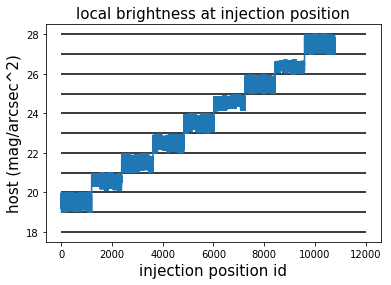

In [24]:
for i in range(18, 29):
    plt.hlines(y=i, xmin=0, xmax=12000)
plt.ylabel('host (mag/arcsec^2)', size= 15)
plt.xlabel('injection position id', size= 15)
plt.title('local brightness at injection position', size= 15)
plt.plot(mag_arr)